In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
data_dir = '../input/gtsrb-german-traffic-sign/'
train_path = '../input/gtsrb-german-traffic-sign/Train/'
test_path = '../input/gtsrb-german-traffic-sign/Test/'
height = 50
width = 50

In [47]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [48]:
batch_size = 150
seed = 42

In [51]:
# train_datagen = ImageDataGenerator(rescale=1./255,
                                   # shear_range = 0.2,
                                   # zoom_range = 0.2,
                                   # horizontal_flip = True)
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    zoom_range=0.1,
#                                    rotation_range=5,
#                                    height_shift_range=0.1,
#                                    width_shift_range=0.1,
#                                    shear_range=0.1,
#                                    horizontal_flip=True,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')
test_dataset = test_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                  subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


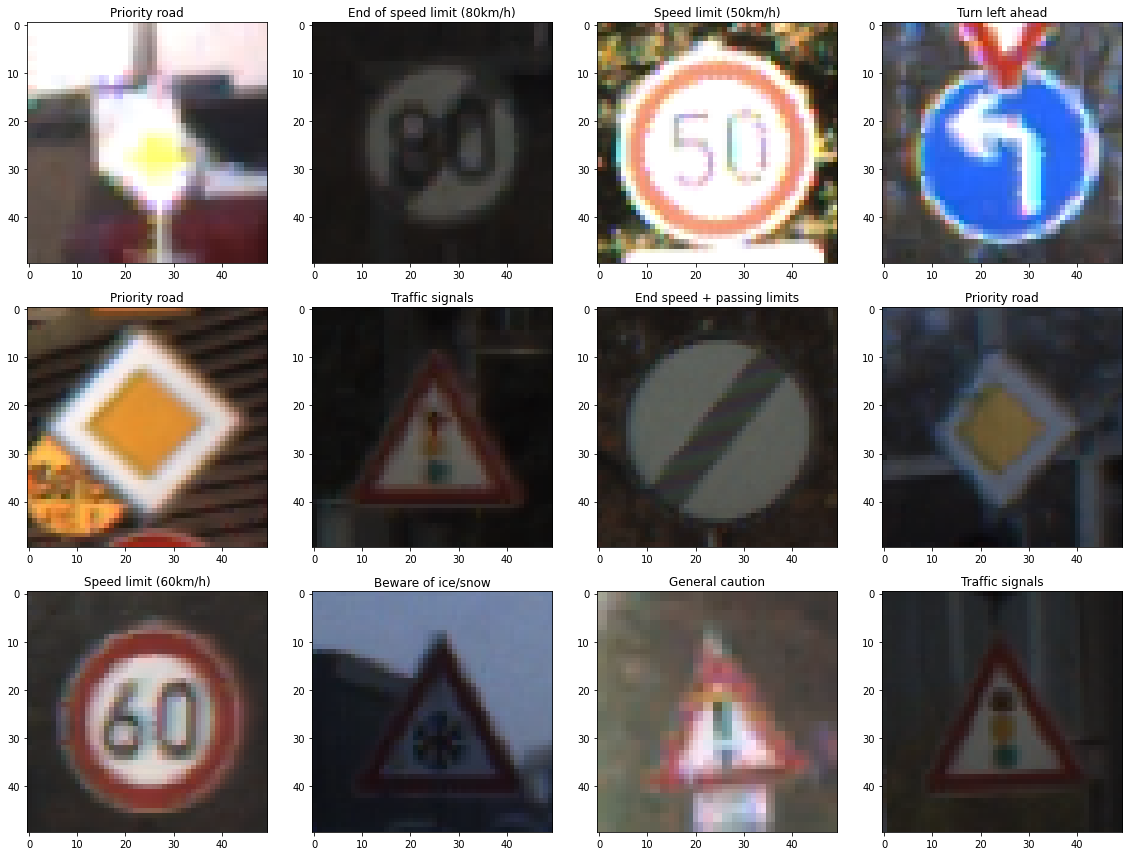

In [52]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [53]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),
    
    keras.layers.Dense(43, activation='softmax')
])

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

In [55]:
alpha=0.01
epochs=15
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [56]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/15
210/210 [==============================] - 40s 185ms/step - loss: 0.5893 - accuracy: 0.8527 - val_loss: 0.7716 - val_accuracy: 0.8105
Epoch 2/15
210/210 [==============================] - 39s 187ms/step - loss: 0.0590 - accuracy: 0.9828 - val_loss: 0.7794 - val_accuracy: 0.8278
Epoch 3/15
210/210 [==============================] - 40s 188ms/step - loss: 0.0383 - accuracy: 0.9880 - val_loss: 0.5716 - val_accuracy: 0.8774
Epoch 4/15
210/210 [==============================] - 38s 181ms/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.2951 - val_accuracy: 0.9390
Epoch 5/15
210/210 [==============================] - 37s 178ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.3173 - val_accuracy: 0.9399
Epoch 6/15
210/210 [==============================] - 38s 179ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.3098 - val_accuracy: 0.9421
Epoch 7/15
210/210 [==============================] - 38s 181ms/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.4555 - val_ac

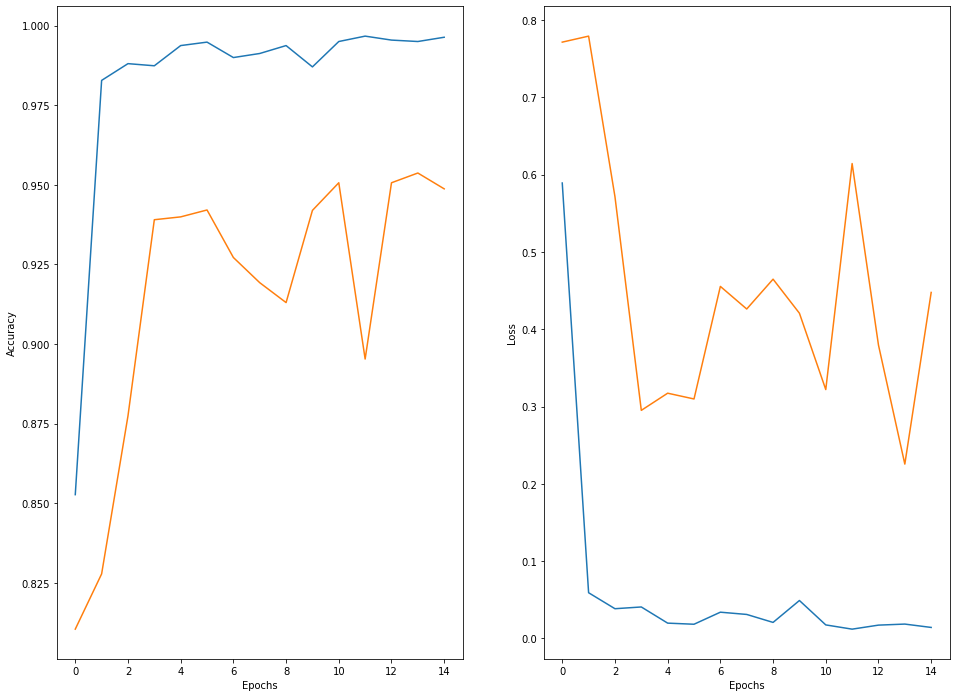

<Figure size 720x504 with 0 Axes>

In [70]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# performance[['loss','val_loss']].plot()
# performance[['accuracy','val_accuracy']].plot()
plt.show()

In [71]:
model.save("CNN.h5")

In [72]:
test_df = pd.read_csv(data_dir + 'Test.csv')

labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [75]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = pred.argmax(axis=-1)
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy: 92.286619160728424


In [ ]:
test_df = pd.read_csv(data_dir + 'Test.csv')
datagen = ImageDataGenerator(rescale=1./255)
test = datagen.flow_from_dataframe(test_df,
                                   x_col='Path',
                                   y_col = 'ClassId',
                                   classes = list(classes.values())
                                   target_size=(35, 35),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb')

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (35, 35, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

2022-04-27 04:53:46.690227: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
trans_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.2),
                                   keras.layers.Dense(43, activation='softmax')                                    
                                ])
trans_model.summary()

In [11]:
alpha=0.0001
epochs=30
optim = keras.optimizers.Adam(learning_rate=0.01)
trans_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

NameError: name 'trans_model' is not defined

In [ ]:
history = trans_model.fit(train_dataset,
                          steps_per_epoch=len(train_dataset),
                          epochs=30,
                          validation_data=test_dataset,
                          validation_steps=len(test_dataset))

In [11]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_3 (Dense)              (None, 43)                22059     
Total params: 24,243,307
Trainable params: 24,242,283
Non-trainable params: 1,024
_________________________________________________________________


In [12]:
alpha=0.0001
epochs=5
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
history = vgg_model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,)
#                     validation_split=0.1)

Epoch 1/5
262/262 [==============================] - 214s 801ms/step - loss: 0.2937 - accuracy: 0.9320
Epoch 2/5
262/262 [==============================] - 145s 554ms/step - loss: 0.0097 - accuracy: 0.9981
Epoch 3/5
262/262 [==============================] - 145s 553ms/step - loss: 0.0086 - accuracy: 0.9983
Epoch 4/5
262/262 [==============================] - 145s 554ms/step - loss: 0.0021 - accuracy: 0.9997
Epoch 5/5
262/262 [==============================] - 145s 554ms/step - loss: 0.0133 - accuracy: 0.9969


In [50]:
pred = vgg_model.predict(X_test)
pred = pred.argmax(axis=-1)

In [34]:
import numpy as np
from keras.preprocessing import image
test_image1 = image.load_img('../input/gtsrb-german-traffic-sign/Test/00002.png', target_size = (height, width))
test_image2 = image.img_to_array(test_image1)#/255.
test_image = np.expand_dims(test_image2, axis = 0)
result = vgg_model.predict(test_image)

In [37]:
result

array([[1.04184946e-05, 1.27192543e-05, 9.73445185e-06, 1.25415527e-05,
        5.12761699e-06, 1.71221973e-06, 1.12683983e-05, 1.20082304e-05,
        2.65753556e-06, 2.11016959e-06, 1.30691706e-06, 8.48834588e-06,
        5.09015990e-06, 1.05280724e-05, 4.20074548e-06, 1.15278235e-05,
        2.92617051e-06, 1.24952194e-05, 4.90643197e-06, 1.51136317e-06,
        2.42506871e-06, 2.57889478e-05, 1.40396451e-05, 4.63548758e-06,
        3.77028373e-05, 2.39225778e-06, 3.08700828e-06, 3.80056622e-06,
        1.68635361e-05, 1.14420409e-05, 2.99709995e-06, 4.91176888e-06,
        9.99638200e-01, 1.29647897e-05, 2.00890395e-06, 5.19212381e-06,
        5.66146673e-06, 9.65178242e-06, 1.31637307e-05, 3.11056124e-06,
        2.20246966e-05, 9.96215385e-06, 4.67106429e-06]], dtype=float32)

In [36]:
result.argmax(axis=-1)

array([32])

In [39]:
image = cv2.imread('../input/gtsrb-german-traffic-sign/Test/00002.png')
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((height, width))
image= np.array(resize_image)/255
image = image.reshape(1,height,width,3)

In [56]:
classes[labels[15]]

'No passing'

In [40]:
classes[int(vgg_model.predict(image).argmax(axis=-1))]

'End speed + passing limits'

In [51]:
from sklearn.metrics import accuracy_score
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  4.465558194774347
